# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are 2 main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then those patterns can be adapted to our data.

## Different types of Transfer Learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own).
* **"Feature Extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g.1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).

## Downloading and inspecting the data

In [ ]:
# Get data (10% of 10 Food Classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-09-05 14:38:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.1MB/s    in 4.5s    

2023-09-05 14:39:02 (35.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

#Walk through 10% data directory & list number of files
for dirpath, dirnames, filenames, in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Create some data loaders (preparing the data)

We'll use the 'ImageDataGenerator' class to load in our images in batches

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (they run whilst our model trains)

Callbacks are an extra functionality that can be added to models to be performed during or after training.Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.


In [ ]:
# Create tensorboard callback (functionized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


🔑**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like.The log_dir parameter we've created above is only one option.

## Creating models using TensorFlow Hub *TensorFlow Hub no longer exists so this is just to show previous work done.

In the past we used TensorFlow to create our own models layer by layer. Now, we're going to have a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [ ]:
#Let's compare the following 2 models:

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# import dependencies:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create() function to create a model from a URL
def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
   model_url(str): A TensorFlow Hub feature extraction URL.
   num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
   An uncompiled Keras Sequential model with model_url as feature extractor layer, and Dense output layer with num_classes output neurons.
  """
# Download the pre-trained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=False,
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SHAPE+(3,)) #Freezes the already learned patterns

# Create sequential model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
])

  return model



### Creating and testing the Resnet TensorFlow Hub Feature Extraction Model

In [ ]:
# Create Resnet Model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our Resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our Resnet model to the data
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230905-143916
Epoch 1/5
24/24 [==============================] - 28s 631ms/step - loss: 2.0889 - accuracy: 0.2880 - val_loss: 1.3377 - val_accuracy: 0.5608
Epoch 2/5
24/24 [==============================] - 10s 439ms/step - loss: 0.9817 - accuracy: 0.6973 - val_loss: 0.8927 - val_accuracy: 0.7136
Epoch 3/5
24/24 [==============================] - 11s 461ms/step - loss: 0.6537 - accuracy: 0.8187 - val_loss: 0.7725 - val_accuracy: 0.7428
Epoch 4/5
24/24 [==============================] - 11s 468ms/step - loss: 0.5073 - accuracy: 0.8680 - val_loss: 0.7306 - val_accuracy: 0.7540
Epoch 5/5
24/24 [==============================] - 13s 547ms/step - loss: 0.3954 - accuracy: 0.9107 - val_loss: 0.6940 - val_accuracy: 0.7712


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Our Transfer Learning Feature Extractor outperformed ALL previous models we built by hand & with a quicker training time & with only 10% of the training examples

In [ ]:
# Create function to plot loss curves
# Tidbit: you could put this function into a script called "helper.py" and import it when you need it.
import matplotlib.pyplot as plt


# Plot validation and training curves
def plot_loss_curves(history):
  """
  returns separate loss curves for training and validation metrics.

  Args:
  history: is a TensorFlow History object.

  Returns:
  Plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

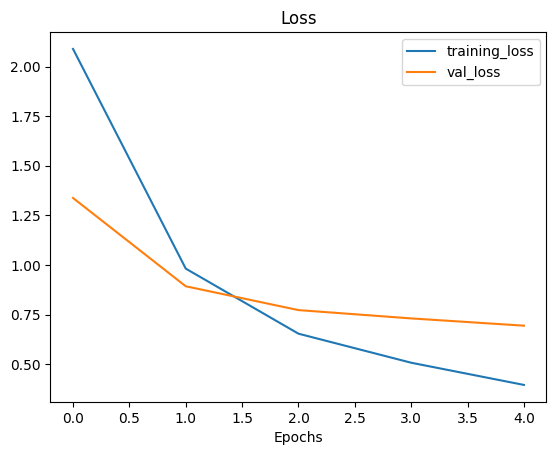

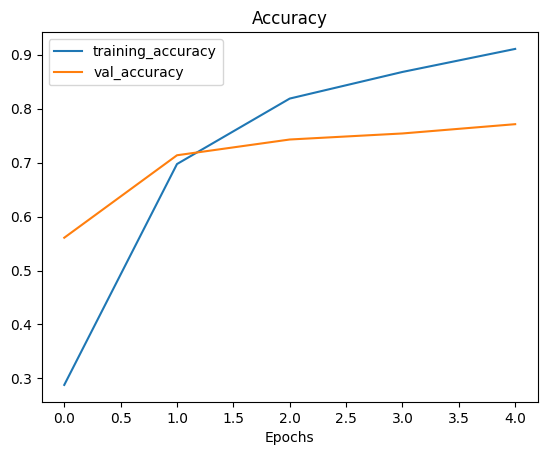

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing the EfficientNetB0 TensorFlow Hub Feature Extraction Model

In [ ]:
# Create EfficientNetB0 Feature Extractor Model : https://blog.research.google/2019/05/efficientnet-improving-accuracy-and.html?m=1
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes= train_data_10_percent.num_classes)

# Compile model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230905-144116
Epoch 1/5
24/24 [==============================] - 25s 619ms/step - loss: 1.8773 - accuracy: 0.4013 - val_loss: 1.3181 - val_accuracy: 0.7176
Epoch 2/5
24/24 [==============================] - 12s 488ms/step - loss: 1.0724 - accuracy: 0.7853 - val_loss: 0.8682 - val_accuracy: 0.8204
Epoch 3/5
24/24 [==============================] - 11s 452ms/step - loss: 0.7566 - accuracy: 0.8400 - val_loss: 0.6948 - val_accuracy: 0.8368
Epoch 4/5
24/24 [==============================] - 11s 455ms/step - loss: 0.6036 - accuracy: 0.8587 - val_loss: 0.6082 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 11s 460ms/step - loss: 0.5110 - accuracy: 0.8840 - val_loss: 0.5536 - val_accuracy: 0.8616


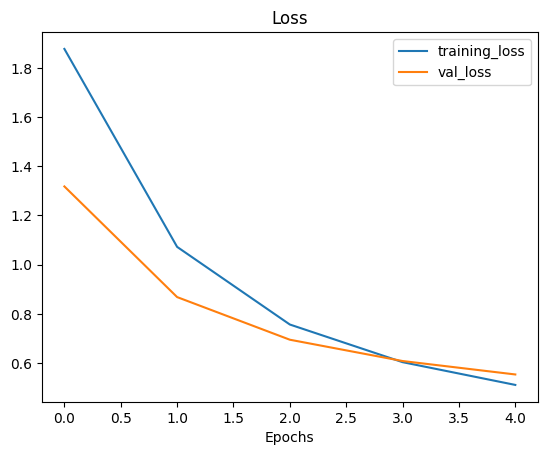

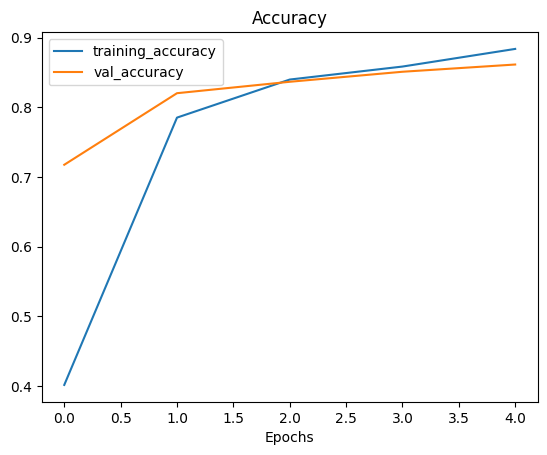

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does the efficientnetb0 feature extractor have?

len(efficientnet_model.layers[0].weights)

309

## Comparing our models results using TensorBoard *TensorBoard does not exist anymore, therefore this is just to show work done at the time.

🔑 **Note:** When uploading things to TensorBoard.dev, your experiments are public therefore if running private experiments, do not upload them.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Coparing 2 Different TF Hub Feature Extraction Model Architectures using 10% of the Training Data" \
  --one_shot


2023-09-05 14:43:01.733682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   QFF-FWD-ZQJ

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-pack

Our TensorBoard experiments are uploaded publicly here: https://tensorboard.dev/experiment/rzfO1YqjQMG2Gdh4w8S8Tw/

In [ ]:
# Check what TensorBoard experiments you have
!tensorboard dev list

2023-09-04 15:06:26.242950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/rzfO1YqjQMG2Gdh4w8S8Tw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Coparing 2 Different TF Hub Feature Extraction Model Architectures using 10% of the Training Data
	Id                   rzfO1YqjQMG2Gdh4w8S8Tw
	Created              2023-09-04 15:00:28 (6 minutes ago)
	Updated              2023-09-04 15:00:30 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811189
Total: 1 experiment(s)


In [ ]:
# How to delete an experiment:
#!tensorboard dev delete --experiment_id

# Confirm the deletion but rechecking what experiments you have left.
# !tensorboard dev list

In [ ]:
# Create model MobileNetV2 and run on current data, see how performs next to other 2.

mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"


In [ ]:
# import dependencies:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create() function to create a model from a URL
def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
   model_url(str): A TensorFlow Hub feature extraction URL.
   num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
   An uncompiled Keras Sequential model with model_url as feature extractor layer, and Dense output layer with num_classes output neurons.
  """
# Download the pre-trained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=False,
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SHAPE+(3,)) #Freezes the already learned patterns

# Create sequential model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
])

  return model



In [ ]:
# Create Resnet Model
mobilenet_model = create_model(mobilenet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [ ]:
# Let's fit our Resnet model to the data
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="mobilenetv2")])

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20230905-145316
Epoch 1/5
24/24 [==============================] - 15s 428ms/step - loss: 1.9371 - accuracy: 0.3400 - val_loss: 1.2879 - val_accuracy: 0.6108
Epoch 2/5
24/24 [==============================] - 10s 428ms/step - loss: 1.0363 - accuracy: 0.7053 - val_loss: 0.8834 - val_accuracy: 0.7396
Epoch 3/5
24/24 [==============================] - 10s 416ms/step - loss: 0.7190 - accuracy: 0.8067 - val_loss: 0.7500 - val_accuracy: 0.7768
Epoch 4/5
24/24 [==============================] - 10s 410ms/step - loss: 0.5713 - accuracy: 0.8560 - val_loss: 0.6832 - val_accuracy: 0.7924
Epoch 5/5
24/24 [==============================] - 12s 534ms/step - loss: 0.4629 - accuracy: 0.8960 - val_loss: 0.6442 - val_accuracy: 0.8004


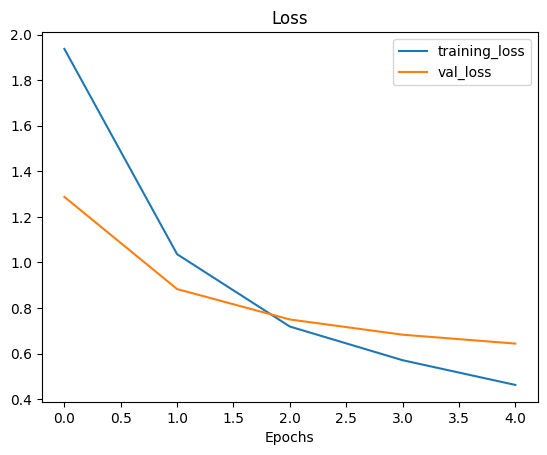

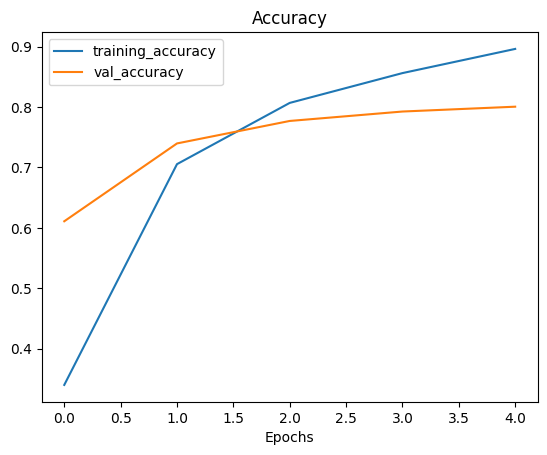

In [ ]:
plot_loss_curves(mobilenet_history)